filename: minianalysis__models_run_on_last_year_vs_next_year.py

description: 
    last updated: 6/13/2014
    Run model on last year of data used vs. next available year of data, as long as it is within a provided bound    
    
inputs:

outputs:

@author: Misha


In [7]:
from __future__ import division

import numpy as np
import pandas as pd
import pickle

import sys
sys.path.append('../')    
import GSSUtility as GU # note, this imports the .PY file, so if I made changes to the IPYNB file, I first need to convert it 
                        # to PY for changes to actually take effect
                        # conversion can be done with 'jupyter nbconvert --to script GSSUtility.py'import numpy as np
from numpy import nan
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict

In [34]:
try: 
    %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
    reload(GU)
except:
    pass

In [35]:
#*********************************************************
allPropsForYearsUsed = []
allPropsForYearsPossible =[]
allParamSizesForYearsUsed = []
allParamSizesForYearsPossible = []
allRsForYearsUsed, allRsForYearsPossible = [], []

 
############################################################
if __name__ == "__main__":    

    try:
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=True, \
                                        centralIVs=False, nextYearBound=3, linearModels=True)            
    print 'len of articleClasses:', len(articlesToUse)
#     raw_input('...')
    
    # define the storage containers for outputs
    group1 = 'on last GSS year'
    group2 = 'on first "future" GSS year'   
    groups = [group1, group2]
    outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
                'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for group in groups:
        for outcome in outcomes:
            output[group][outcome] = []
    
#     log=open('log_file.txt', 'w')       
#     for article in random.sample(articlesToUse, 200):
    for article in articlesToUse:
    #for article in [a for a in articlesToUse if a.articleID == 6755]:
    
        print '\n===================\nProcessing article:', article.articleID
        
        RHS = article.IVs + article.controls
        
        for DV in article.DVs:
#             print DV, '~', RHS
            maxYearUsed = max(article.GSSYearsUsed)
            futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]
            nextYear = min(futureYearsPossible) # the arguments of GU.filterArticles function ensure that there is a suitable future year (within bound)
            
#             log.write('id'+str(article.articleID)+' year '+str(maxYearUsed))
            
            resOnDataUsed = GU.runModel(dataCont, maxYearUsed, DV, RHS); # models run on max year of data used
            if not resOnDataUsed: continue
            
#             log.write('id'+str(article.articleID)+' year '+str(nextYear))           
            resOnNextYear = GU.runModel(dataCont, nextYear, DV, RHS); # models run on min year of future data
            if not resOnNextYear: continue
            
            # Checks on which results to record                
            if len(resOnDataUsed.params) != len(resOnNextYear.params):
                print 'The number of variables in original model is different from the number in model on future years. Skipping.'                    
                continue
            
            # the condition below means that i don't care about models in which orig var isn't stat. sig.
#            if results.pvalues[-1] > 0.05: continue
            results = [resOnDataUsed, resOnNextYear]
 
            centralVars = []            
            for civ in article.centralIVs:
                if 'standardize(%s, ddof=1)' % (civ) in results[0].params.index:
                    centralVars.append('standardize(%s, ddof=1)' % (civ))
                else: 
                    for col in results[0].params.index:
                        if 'C(' + civ + ')' in col:
                            centralVars.append(col)
 
#           print 'IVs:', article.IVs
#           print 'centralVas:', centralVars
#           raw_input('...')
            '''                
            centralVars = ['standardize(%s, ddof=1)' % (cv) for cv in article.centralIVs]
            centralVars = set(centralVars).intersection(results[0].params.index) # need this step because some central                                                                                            # var columns may be removed when running model
            '''

            # The reasoning for the condition below is that authors make two types of arguments for "central" variables, 
            # (1) that the central variable is really important, p < 0.05, or (2) that the central variable is not important (p > 0.05). 
            # What we want to test by replacing the variable with a cognate are arguments of type (1). 
            # Arguments of type (2) are important and testable too, but if we test all of these together, we will obscure both effects.
            # So the condition below ensures that at least one of the central variables was found to be "important" in the original 
            # article.
            # This throws away 67 observations.
#             if np.all(results[0].pvalues[centralVars] > 0.05): 
#                 print 'All "central" IVs are p > 0.05. Skipping.'
#                 continue
                
            for i in range(2):                 
                output[groups[i]]['Rs'].append(results[i].rsquared) 
                output[groups[i]]['adjRs'].append(results[i].rsquared_adj) 
                output[groups[i]]['propSig'].append(float(len([p for p in results[i].pvalues[1:] if p < 0.05]))/len(results[i].params[1:])) 
                output[groups[i]]['paramSizesNormed'].append(np.mean(results[i].params[1:].abs())) 
                output[groups[i]]['pvalues'].append(np.mean( results[i].pvalues[1:]))
                output[groups[i]]['numTotal'].append( 1 ) #divide by len of R^2 array to get a mean of variables estimated PER model                           
                
                if len(centralVars)>0:
                    output[groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars]))               
                    output[groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
                                                            /len(results[i].params[centralVars])) 
                    output[groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                
                else:
                    output[groups[i]]['pvalues_CentralVars'].append(np.nan)
                    output[groups[i]]['propSig_CentralVars'].append(np.nan)
                    output[groups[i]]['paramSizesNormed_CentralVars'].append(np.nan)
                    
            output['metadata']['article_id'].append(article.articleID)                 
     
   
pickle.dump(output, open('output.pickle', 'w'))    
#     print 'TTests'
#     for outcome in outcomes:
#         print 'Means of group1 and group2:', np.mean(output[group1][outcome]), np.mean(output[group2][outcome]), 'Paired T-test of ' + outcome, ttest_rel(output[group1][outcome], output[group2][outcome])


len of articleClasses: 216

Processing article: 2558
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant

Processing article: 4266
Either the  params or the R^2 is too high. Skipping.
standardize(POSTMAT1, ddof=1) ~ standardize(AGE, ddof=1) + standardize(COHORT, ddof=1) + standardize(EDUC, ddof=1) + C(SEX)
Either the  params or the R^2 is too high. Skipping.
standardize(POSTMAT2, ddof=1) ~ standardize(AGE, ddof=1) + standardize(COHORT, ddof=1) + standardize(EDUC, ddof=1) + C(SEX)
Either the  params or the R^2 is too high. Skipping.
standardize(RINCOME, ddof=1) ~ standardize(AGE, ddof=1) + standardize(COHORT, ddof=1) + standardize(EDUC, ddof=1) + C(SEX)

Processing article: 6439

Processing article: 1043
The number of variables in original model is different from the number in model on future years. Skipping.

Processing article: 4133

Processing article: 5096

Processing article: 1211

Processing article: 6840

Processing article: 224
Either th


Processing article: 2943
Couldnt construct a suitable formula

Processing article: 2974
Couldnt construct a suitable formula
Couldnt construct a suitable formula

Processing article: 2984

Processing article: 3037

Processing article: 3094
Couldnt construct a suitable formula
Couldnt construct a suitable formula

Processing article: 3164

Processing article: 3231

Processing article: 3250
Dropping column WKSUP because it is constant
Couldnt construct a suitable formula
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Couldnt construct a suitable formula
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is co

Couldnt construct a suitable formula

Processing article: 5859

Processing article: 3141
Couldnt construct a suitable formula

Processing article: 6340

Processing article: 7432
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula

Processing article: 3298

Processing article: 3400

Processing article: 4397
Couldnt construct a suitable formula

Processing article: 4743
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it i

Create dataframe that contains the output 
--

In [2]:
output = pickle.load(open('output.pickle'))
group1 = 'on last GSS year'
group2 = 'on first "future" GSS year'   
groups = [group1, group2]
outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
            'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

In [3]:
df_output = pd.DataFrame(index=np.arange(len(output[group1]['propSig'])), columns=pd.MultiIndex.from_product([groups, outcomes]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[gp, outcome] = output[gp][outcome]
df_output['article_id'] = output['metadata']['article_id']
del df_output[group1, 'numTotal']
del df_output[group2, 'numTotal']
df_output.head()
# df_output.to_pickle('df_output.pickle')
# df_output

outcomes.remove('numTotal')

print 'Number of unique articles used:', len(df_output['article_id'].unique())

NameError: name 'np' is not defined

In [37]:
# output article IDs for use in replication project. 2016-06-07
fout = open('minianalysis_next_year_list_of_articles_used.csv',  'wb')
fout.write(','.join(map(str, sorted(df_output.article_id.unique())))) # unique article IDs used, separated by commas
fout.close()

In [38]:
# if using another, non-ipython notebook method of running the code
# load in the output of that other method, and set up the relevant variables
# df_output = pd.read_pickle('df_output.pickle')
# group1 = 'on last GSS year'
# group2 = 'on first "future" GSS year'   
# groups = [group1, group2]
# outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
#             'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

Plot the output
--

In [39]:
import matplotlib.pyplot as plt
import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)
%matplotlib inline

In [40]:
# %matplotlib inline

# outcomesToUse = df_output[group1].columns
# indices = np.arange(len(outcomesToUse))
# width = 0.35
# axes = plt.figure(figsize=(12,8)).add_subplot(111)
# error_config = {'ecolor': '0.3'}
# rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='r', 
#                  yerr=df_output[group1].std()/np.sqrt(len(df_output[group1])), error_kw=error_config) 
# rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='y', 
#                  yerr=df_output[group2].std()/np.sqrt(len(df_output[group2])), error_kw=error_config)

# # title, legend, etc
# plt.title('Models Using Last GSS Year vs. First "Future" Year', fontsize=18)
# plt.legend((rects1[0], rects2[0]), ('Last Yr.', '1st Future Yr.'), fontsize=15)
# plt.xlim((-1*width, len(outcomesToUse)))

# # tick labels
# # a = outcomesToUse
# a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
#      '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
# axes.set_xticks(indices+width)
# axes.set_xticklabels(a, rotation=90, fontsize=15)

# # label the bars with the difference between them
# diffs = (df_output[group1] - df_output[group2]).mean().values
# def autolabel(rects):
#     # attach some text labels
#     for i, rect in enumerate(rects):
#         height = rect.get_height()
#         if i!=7 and i!=4:
#             axes.text(rect.get_x()+width, 1.02*height, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
#         else: # this is for the p-value label, which has gone up
#             axes.text(rect.get_x()+width, 1.02*height+0.05, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
# autolabel(rects1)

# # savefig('../../Images/ASA2015/models_using_last_gss_year_vs_first_future_year.png', bbox_inches='tight')

In [41]:
# print outcomesToUse
# print 
# print diffs
# print
# print diffs_strings

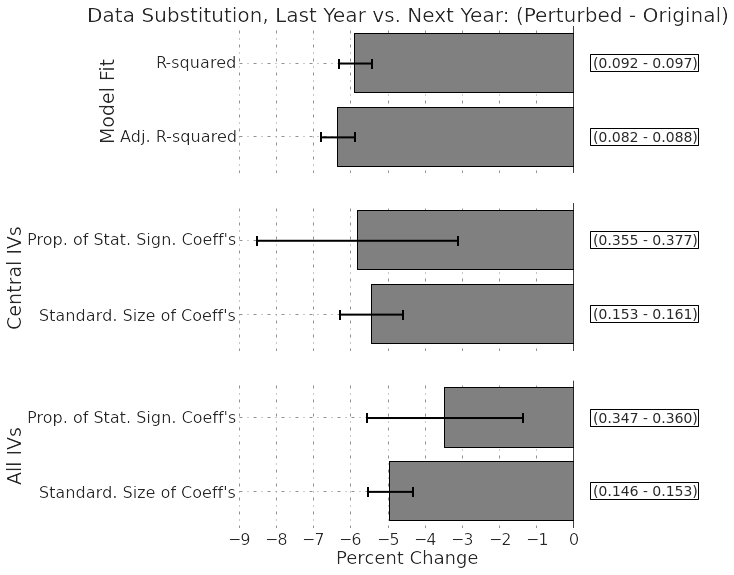

In [94]:
# fig = plt.figure(figsize=(6,9))
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed',
                 u'propSig']

outcomeMap = {'propSig':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}

# indices = [1,2,4,5,7,8]
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)

diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group2, outcome].mean(), df_output[group1, outcome].mean()) 
                 for outcome in outcomesToUse]
diffs = np.array(diffs)

# naive SES
# ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# clustered SES
clusteredSES = []
article_ids = np.array(list(df_output.index)) 
for outcome in outcomesToUse:
    diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mask = ~np.isnan(np.array(diff))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
    clusteredSES.append(result_clustered.HC0_se[0])   
clusteredSES = np.array(clusteredSES)

# CONSERVATIVE TESTs
# these will be based only on n. of articles
conservativeSES = []
for outcome in outcomesToUse:
    df_output_copy = df_output.copy()
    df_output_copy['difference'] = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mean_difference = df_output_copy.groupby('article_id').difference.mean()
    se = np.std(mean_difference) / np.sqrt(len(mean_difference))
    conservativeSES.append(se)
conservativeSES = np.array(conservativeSES)

colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
#     xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    xerr = 2*conservativeSES[i*2:i*2+2]
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)

    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + .5 # the indices here mean get the x-coord of 2nd box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + .5

    axarr[i].text(box0_xcoord, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)        
    
axarr[0].set_title('Data Substitution, Last Year vs. Next Year: (Perturbed - Original)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('All IVs', fontsize=19)
axarr[2].set_xlabel('Percent Change', fontsize=18)
plt.xticks(fontsize=16)
# plt.xlim(-10, 50)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

plt.savefig('images/last-vs-next--original-minus-perturbed.svg', bbox_inches='tight', dpi=150)

In [75]:
from scipy.stats import ttest_1samp

df_output_copy = df_output.copy()
df_output_copy['difference'] = 100*(df_output[group2, outcome] - df_output[group1, outcome])

# mask = df_output_copy.loc[:,(slice(None), outcome)].notnull().all(axis=1)
mean_diff = df_output_copy.groupby('article_id').difference.mean()

ttest_1samp(mean_diff, 0)
se = mean_diff / np.std(mean_diff) / sqrt(len(mean_diff))



Ttest_1sampResult(statistic=-1.1651712150853109, pvalue=0.24539523819694023)

In [45]:
# from scipy.stats import ttest_rel

for outcome in outcomesToUse:
    df_output_copy = df_output.copy()
    df_output_copy['difference'] = 100*(df_output[group2, outcome] - df_output[group1, outcome])

    # mask = df_output_copy.loc[:,(slice(None), outcome)].notnull().all(axis=1)
    mean_diff = df_output_copy.groupby('article_id').difference.mean()
    se = np.std(mean_diff) / sqrt(len(mean_diff))
    
    

outcome on last GSS year                                                     \
group            propSig paramSizesNormed        Rs     adjRs       pvalues   
0               0.200000         0.093842  0.039096  0.028324  3.970354e-01   
1               0.736842         0.306411  0.116589  0.105495  6.752392e-02   
2               0.473684         0.167137  0.160020  0.149472  1.843961e-01   
3               0.105263         0.107652  0.041863  0.029830  3.807866e-01   
4               0.263158         0.128956  0.097776  0.086446  3.372795e-01   
5               0.263158         0.114445  0.088832  0.077390  3.801695e-01   
6               0.210526         0.130659  0.093716  0.082335  3.152730e-01   
7               0.368421         0.141070  0.096843  0.085501  3.176037e-01   
8               0.210526         0.092056  0.058819  0.046999  4.634258e-01   
9               0.684211         0.244581  0.139293  0.128484  5.262702e-02   
10              0.315789         0.114332  0.133616  0.122736  3.933321e-01   
11              0.210526         0.089914  0.046160  0.034182  4.347374e-01   
12              0.157895         0.124551  0.093841  0.082461  3.212611e-01   
13              0.263158         0.132139  0.108722  0.097530  2.700530e-01   
14              0.157895         0.097885  0.113045  0.101907  3.761466e-01   
15              0.157895         0.093650  0.088803  0.077360  3.897126e-01   
16              0.157895         0.100344  0.108970  0.097781  4.298221e-01   
17              0.210526         0.088671  0.104355  0.093108  4.482170e-01   
18              0.400000         0.119753  0.070714  0.064847  2.385641e-01   
19              1.000000         0.156419  0.024467  0.023755  5.730039e-09   
20              0.800000         0.406119  0.128299  0.125444  1.151179e-01   
21              0.500000         0.235060  0.122874  0.115640  3.392651e-01   
22              0.333333         0.148771  0.095451  0.074050  3.487093e-01   
23              1.000000         0.228176  0.052064  0.051446  1.440495e-19   
24              0.000000         0.030916  0.001787  0.000479  3.122487e-01   
25              1.000000         0.053786  0.003894  0.002589  4.679524e-02   
26              0.285714         0.295029  0.165020  0.135046  2.177303e-01   
27              0.421053         0.144937  0.036166  0.023457  2.648851e-01   
28              0.263158         0.126629  0.059573  0.047174  3.257264e-01   
29              0.263158         0.158951  0.083772  0.071691  3.092040e-01   
..                   ...              ...       ...       ...           ...   
780             0.312500         0.127503  0.183836  0.175119  4.423210e-01   
781             0.000000         0.083061  0.003788  0.001591  2.691090e-01   
782             0.500000         0.144125  0.027492  0.025348  1.375763e-01   
783             0.214286         0.171274  0.049880  0.040922  2.609582e-01   
784             0.260870         0.115713  0.070814  0.054818  3.041223e-01   
785             0.217391         0.059577  0.056031  0.039780  4.509019e-01   
786             0.461538         0.195077  0.205662  0.195509  2.596540e-01   
787             0.266667         0.129005  0.215730  0.198027  2.608132e-01   
788             0.266667         0.127661  0.258389  0.241648  2.756373e-01   
789             0.300000         0.096428  0.259484  0.242768  3.779386e-01   
790             0.333333         0.137480  0.277968  0.261670  3.070105e-01   
791             0.233333         0.111283  0.236808  0.219580  3.064573e-01   
792             0.233333         0.098644  0.292640  0.276672  3.729132e-01   
793             0.133333         0.076145  0.099081  0.078745  4.547270e-01   
794             0.133333         0.099288  0.084071  0.063395  3.935530e-01   
795             0.233333         0.090737  0.134243  0.114700  4.180907e-01   
796             0.400000         0.149572  0.182153  0.163691  2.987020e-01   
797             0.333333         0.141056  0.19207

Perform t-tests
--

In [ ]:
# import rpy2.robjects as robjects
# import pandas.rpy.common as com
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# r = robjects.r

# article = articlesToUse[10]
# mydf = dataCont.df.loc[1974, article.DVs+article.IVs]
# mydf.head()

In [ ]:
# # (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

# from scipy.stats import ttest_1samp
# for outcome in outcomes:
#     print outcome
#     print 'mean group 1', df_output[group1, outcome].mean()
#     print 'mean group 2', df_output[group2, outcome].mean()
#     print ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1]
#     print

Perform t-tests and Tests using *clustered errors*
--

1. Perform related-sample t-test (samples must be of equal lengths)

2. Perform independent samples t-test (just for kicks, to see how big our effects are)

3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html

Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Note
--
For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.

Outcome
--
The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?


In [ ]:
# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', np.around(df_output[group1, outcome].mean(), 3)
    print 'Mean after substitution:', np.around(df_output[group2, outcome].mean(), 3)
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                            cov_kwds=dict(groups=df_output.article_id))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'Clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

How many models' avg p-value is above 0.05?
--

In [ ]:
# # need to see tally up how switched from being below to being above
# # i.e. need to condition on being below beforehand, and how many of those are above now

# print 'count:', df_output[group2]['pvalues'][df_output[group2]['pvalues'] > 0.05].shape[0]
# print 'total:', df_output.shape[0]
# print 'percent:', df_output[]['pvalues'][df_output['cognate models']['pvalues'] > 0.05].shape[0]/ df_output.shape[0]